In [1]:
# import the necessary library

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import kaggle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# downlaod the dataset direct from the kaggle api

!kaggle datasets download -d ucsandiego/carbon-dioxide

Dataset URL: https://www.kaggle.com/datasets/ucsandiego/carbon-dioxide
License(s): unknown




  0%|          | 0.00/10.5k [00:00<?, ?B/s]
100%|##########| 10.5k/10.5k [00:00<00:00, 5.59MB/s]


In [2]:
# Name of the zip file
zipfile_name = 'carbon-dioxide.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

print("Extraction completed!")

Extraction completed!


## EXPLORATORY DATA ANALYSIS

In [3]:
# check the extracted file

df = pd.read_csv('archive.csv')

df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [4]:
# look at the tail of the dataset

df.tail()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
715,2017,8,2017.6219,NaN,NaN,NaN,NaN
716,2017,9,2017.7068,NaN,NaN,NaN,NaN
717,2017,10,2017.7890,NaN,NaN,NaN,NaN
718,2017,11,2017.8740,NaN,NaN,NaN,NaN
719,2017,12,2017.9562,NaN,NaN,NaN,NaN


In [5]:
# let's check the bulb information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               720 non-null    int64  
 1   Month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   Carbon Dioxide (ppm)               703 non-null    float64
 4   Seasonally Adjusted CO2 (ppm)      703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.5 KB


In [6]:
# let's check the null values

df.isnull().sum()

Year                                  0
Month                                 0
Decimal Date                          0
Carbon Dioxide (ppm)                 17
Seasonally Adjusted CO2 (ppm)        17
Carbon Dioxide Fit (ppm)             13
Seasonally Adjusted CO2 Fit (ppm)    13
dtype: int64

In [7]:
# let's deal with the null values

df = df.interpolate(method = 'linear', limit_direction='both')

In [8]:
df.isnull().sum()

Year                                 0
Month                                0
Decimal Date                         0
Carbon Dioxide (ppm)                 0
Seasonally Adjusted CO2 (ppm)        0
Carbon Dioxide Fit (ppm)             0
Seasonally Adjusted CO2 Fit (ppm)    0
dtype: int64

In [9]:
# rename the 6th column that will be the target variable for this study

df.rename(columns={'Carbon Dioxide Fit (ppm)': 'CO2emissions'}, inplace=True)

In [10]:
# check the dataset once more

df.head()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),CO2emissions,Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,315.69,314.42,316.18,314.89
1,1958,2,1958.1260,315.69,314.42,316.18,314.89
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [11]:
# let's get the basic statistics of the target variable

df['CO2emissions'].describe()

count    720.000000
mean     352.776611
std       26.898467
min      312.450000
25%      328.417500
50%      349.985000
75%      374.275000
max      407.280000
Name: CO2emissions, dtype: float64

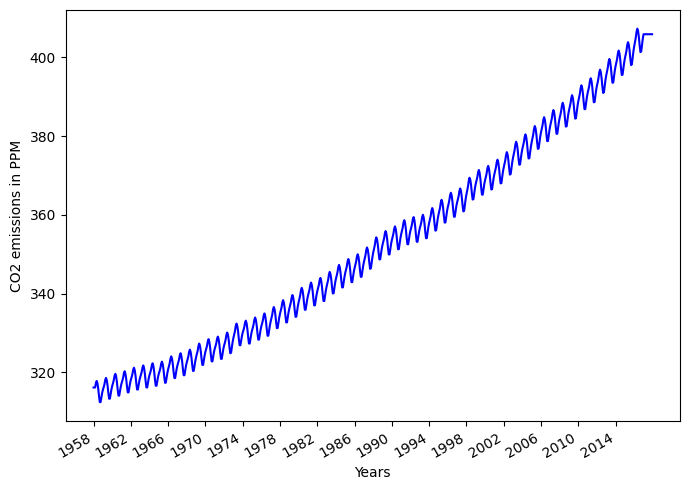

In [12]:
# let's plot the CO2 emissions

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(df['CO2emissions'], 'b-')
ax.set_xlabel('Years')
ax.set_ylabel('CO2 emissions in PPM')

ax.set_xticks(np.arange(0, 719, 48), [1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 
                                      1998, 2002, 2006, 2010, 2014])

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA MODEL

### Stationarity

In [13]:
ADF_test = adfuller(df['CO2emissions'])

print(f'AD_statistic:{ADF_test[0]}')
print(f'p_value:{ADF_test[1]}')

AD_statistic:6.528315177135228
p_value:1.0


In [14]:
diff_df = np.diff(df['CO2emissions'], n=1)

ADF_test = adfuller(diff_df)
print(f'AD_statistic:{ADF_test[0]}')
print(f'p_value:{ADF_test[1]}')

AD_statistic:-2.698304367928553
p_value:0.0743321473383829


In [15]:
# let's perform a seasonal differencing

seasonal_diff = np.diff(diff_df, n=12)

diff_df = np.diff(df['CO2emissions'], n=1)

ADF_test = adfuller(seasonal_diff)
print(f'AD_statistic:{ADF_test[0]}')
print(f'p_value:{ADF_test[1]}')

AD_statistic:-16.10053698452248
p_value:5.13733141401448e-29


### Train/ Test set

In [16]:
train = df['CO2emissions'][:-144]
test = df['CO2emissions'][-144:]

print(f'the length of the train set is:{len(train)}')
print('')
print(f'the length of the test set is:{len(test)}')

the length of the train set is:576

the length of the test set is:144


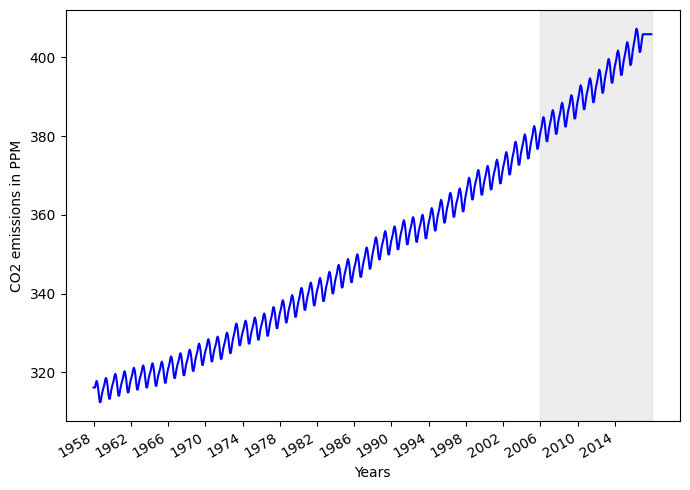

In [17]:
#let's plot the train/test split 

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(df['CO2emissions'], 'b-')
ax.set_xlabel('Years')
ax.set_ylabel('CO2 emissions in PPM')
ax.axvspan(576, 720, color='#A9A9A9', alpha=.2)

ax.set_xticks(np.arange(0, 719, 48), [1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 
                                      1998, 2002, 2006, 2010, 2014])

fig.autofmt_xdate()
plt.tight_layout()

### Model selection

In [18]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False)
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
min_p = 0
max_p = 3
min_q = 0
max_q = 3

min_P = 0
max_P = 3
min_Q = 0
max_Q = 3

d = 1
D = 1
s = 12

result_df = SARIMA_gridsearch(train, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 256 unique models


  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 3, 0)",-2133.156704
1,"(3, 0, 3, 1)",-2133.130666
2,"(1, 3, 3, 1)",-2132.541755
3,"(1, 3, 3, 0)",-2131.971520
4,"(1, 2, 3, 0)",-2131.895561


In [19]:
model = SARIMAX(train, order=(3, 1, 0), seasonal_order=(3, 1, 0, 12))
sarima_model = model.fit(disp=False)

print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       CO2emissions   No. Observations:                  576
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                1073.578
Date:                            Wed, 29 Jan 2025   AIC                          -2133.157
Time:                                    15:03:41   BIC                          -2102.824
Sample:                                         0   HQIC                         -2121.315
                                            - 576                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9317      0.052     18.005      0.000       0.830       1.033
ar.L2          0.2013      0.066   

### Residuals Analysis

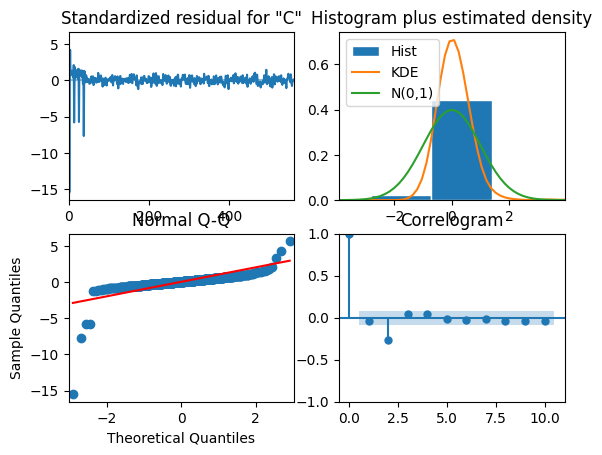

In [20]:
sarima_model.plot_diagnostics();

<p> The residuals are nearly straight on the Q-Q plot. In addition, the first plot shows no trend. 
The histogram suggests that the residuals are normally distributed and the correlogram shows no autocorrelation left; 
therefore, the residuals look like white noise. </p>

In [21]:
# Ljung Box test

residuals = sarima_model.resid

Lb_test = acorr_ljungbox(residuals, lags=np.arange(1,11,1), return_df=True)

#extract p-values

pvalues = Lb_test['lb_pvalue']

# print the p-values

print(f'p-values are:{pvalues}')

p-values are:1     0.964777
2     0.998532
3     0.999629
4     0.999951
5     0.999997
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
Name: lb_pvalue, dtype: float64


the p values are all above 0.05, Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

### Forecasting

In [22]:
def rolling_predictions(df, train_len, horizon, window, period, method):
    TOTAL_LEN = train_len + horizon
    seasonal_steps = int((window / period))

    if method == 'mean':
        pred_mean = [np.mean(df[:i].values) for i in range(train_len, TOTAL_LEN, window)]
        return np.repeat(pred_mean, window)[:horizon]

    elif method == 'last':
        pred_last_value = [df[:i].iloc[-1].values[0] for i in range(train_len, TOTAL_LEN, window)]
        return np.repeat(pred_last_value, window)[:horizon]

    elif method == 'last_season':
        pred_last_season = []  # Correctly initialize `pred_last_season` here
    
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season.flatten().tolist() * seasonal_steps)
        
        # Ensure the predictions match the horizon length
        pred_last_season = pred_last_season[:horizon]
        
        # If the length is still insufficient, repeat values
        if len(pred_last_season) < horizon:
            repeats = (horizon - len(pred_last_season))
            pred_last_season.extend(pred_last_season[:repeats])
        
        return pred_last_season[:horizon]

    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(0,1,4), seasonal_order=(0,1,1,12))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA[:horizon]

    else:
        raise ValueError("Invalid method provided. Choose from ['mean', 'last', 'last_season', 'SARIMA']")


In [23]:
pred_df = test.copy()
pred_df = pred_df.to_frame()

TRAIN_LEN = len(train)
HORIZON = len(test)

windows = [36, 72, 108, 144]

for window in windows:
    pred_last_season = rolling_predictions(df['CO2emissions'], TRAIN_LEN, HORIZON, window, 12, 'last_season')
    pred_SARIMA = rolling_predictions(df['CO2emissions'], TRAIN_LEN, HORIZON, window, 12, 'SARIMA')

    pred_df[f'pred_last_season_{window}'] = pred_last_season
    pred_df[f'pred_SARIMA_{window}'] = pred_SARIMA

pred_df.head()


,CO2emissions,pred_last_season_36,pred_SARIMA_36,pred_last_season_72,pred_SARIMA_72,pred_last_season_108,pred_SARIMA_108,pred_last_season_144,pred_SARIMA_144
576,380.95,378.48,380.959706,378.48,380.959706,378.48,380.959706,378.48,380.959706
577,381.81,379.38,381.833286,379.38,381.833286,379.38,381.833286,379.38,381.833286
578,382.76,380.38,382.804403,380.38,382.804403,380.38,382.804403,380.38,382.804403
579,384.13,381.81,384.188873,381.81,384.188873,381.81,384.188873,381.81,384.188873
580,384.81,382.56,384.883622,382.56,384.883622,382.56,384.883622,382.56,384.883622


In [24]:
pred_df['CO2emissions'] = pd.to_numeric(pred_df['CO2emissions'], errors='coerce')


In [25]:
print(pred_df['CO2emissions'].isna().sum())


0


In [26]:
pred_df['CO2emissions'] = pred_df['CO2emissions'].interpolate()

In [27]:
pred_df.reset_index(drop=True, inplace=True)


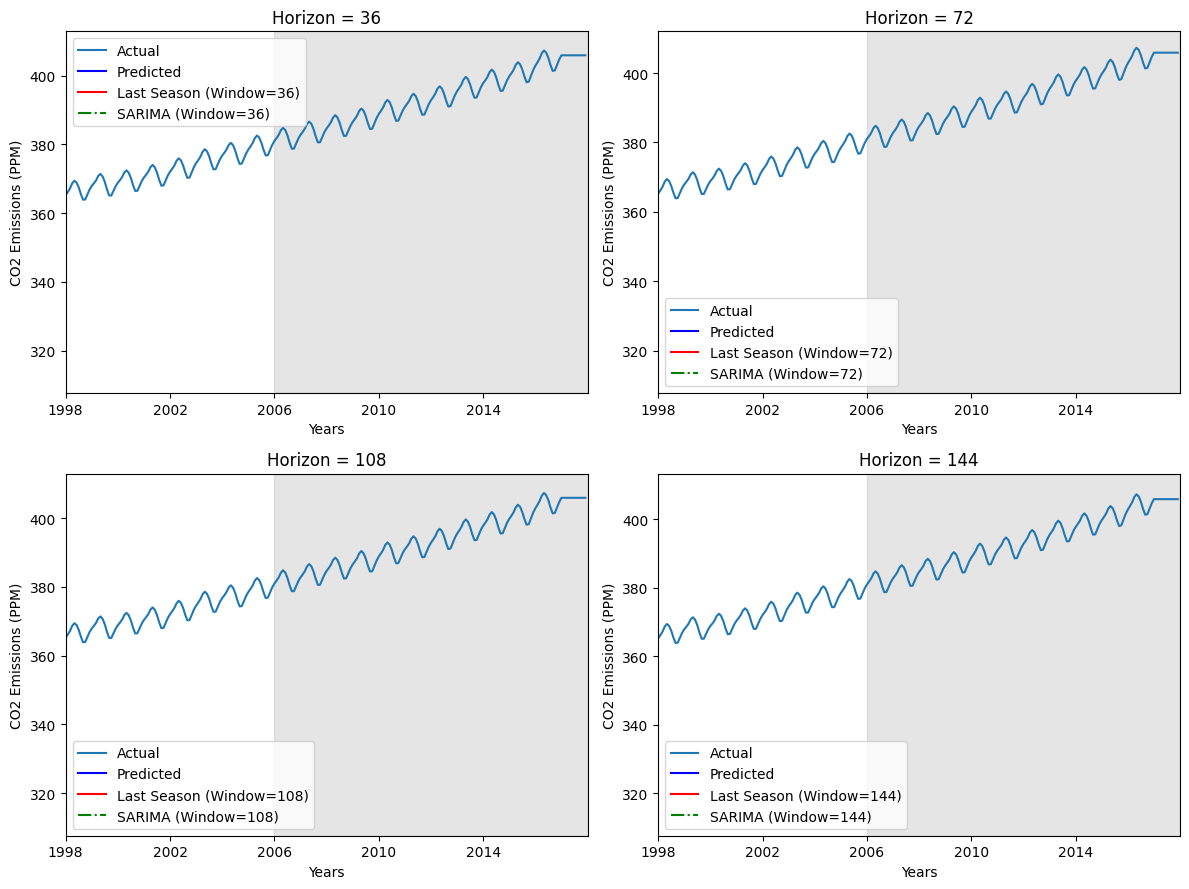

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

for i, ax in enumerate(axes.flatten()):
    window = windows[i]  # Correct window size
    ax.plot(df.index, df['CO2emissions'], label='Actual')
    ax.plot(pred_df.index, pred_df['CO2emissions'], 'b-', label='Predicted')
    ax.plot(pred_df.index, pred_df[f'pred_last_season_{window}'], 'r-', label=f'Last Season (Window={window})')
    ax.plot(pred_df.index, pred_df[f'pred_SARIMA_{window}'], 'g-.', label=f'SARIMA (Window={window})')
    ax.legend(loc='best')
    ax.set_xlabel('Years')
    ax.set_ylabel('CO2 Emissions (PPM)')
    ax.axvspan(576, 720, color='#808080', alpha=0.2)
    ax.set_xticks(np.arange(0, 719, 48))
    ax.set_xticklabels([1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014])
    ax.set_xlim(480, 720)
    ax.set_title(f'Horizon = {window}')

plt.tight_layout()
plt.show()


In [29]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [30]:
mape_naive_seasonal_36 = mape(pred_df['CO2emissions'], pred_df['pred_last_season_36'])
mape_SARIMA_36 = mape(pred_df['CO2emissions'], pred_df['pred_SARIMA_36'])

mape_naive_seasonal_72 = mape(pred_df['CO2emissions'], pred_df['pred_last_season_72'])
mape_SARIMA_72 = mape(pred_df['CO2emissions'], pred_df['pred_SARIMA_72'])

mape_naive_seasonal_108 = mape(pred_df['CO2emissions'], pred_df['pred_last_season_108'])
mape_SARIMA_108 = mape(pred_df['CO2emissions'], pred_df['pred_SARIMA_108'])

mape_naive_seasonal_144 = mape(pred_df['CO2emissions'], pred_df['pred_last_season_144'])
mape_SARIMA_144 = mape(pred_df['CO2emissions'], pred_df['pred_SARIMA_144'])

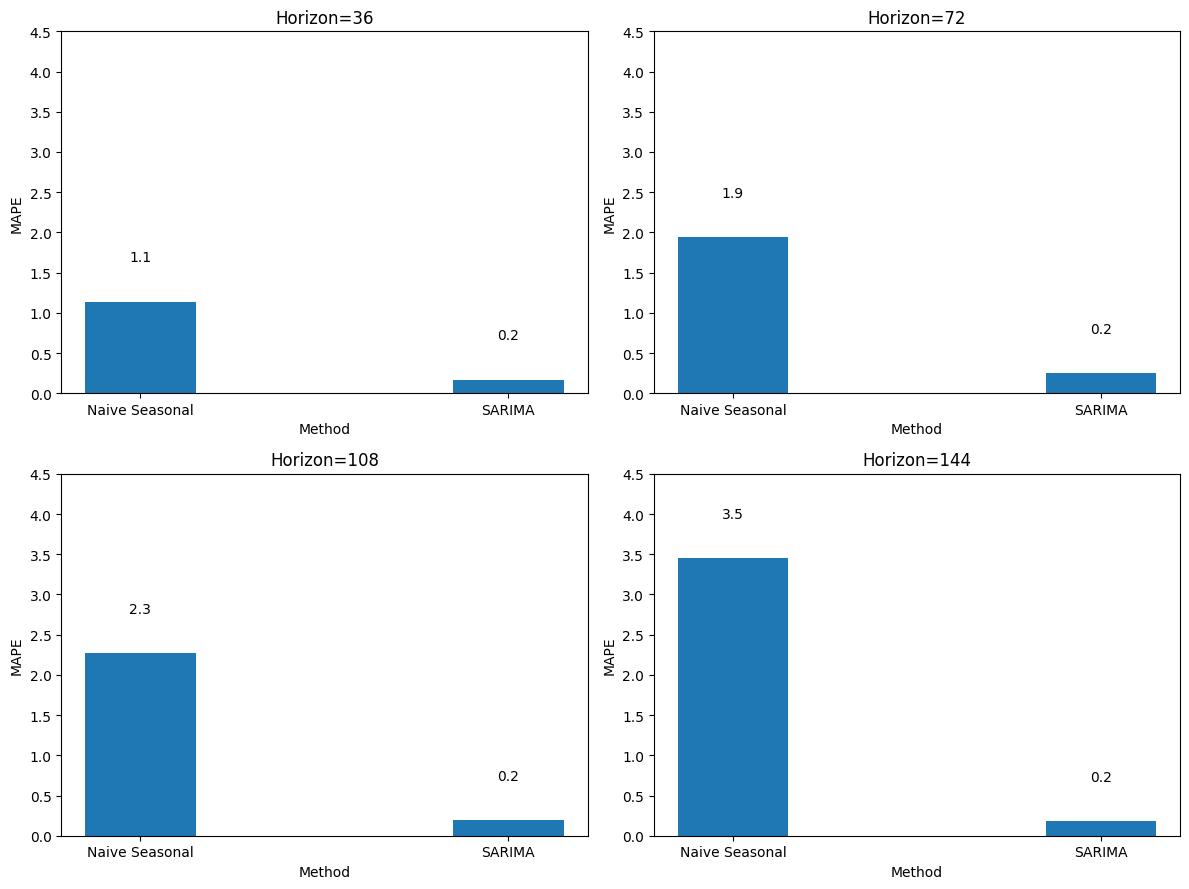

In [31]:
# Example numeric MAPE values
mape_naive_seasonal = [1.14, 1.94, 2.27, 3.45]
mape_SARIMA = [0.17, 0.25, 0.19, 0.18]
windows = [36, 72, 108, 144]  # Horizon values

x_labels = ['Naive Seasonal', 'SARIMA']
width = 0.3

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

# Iterate through subplots
for i, ax in enumerate(axes.flatten()):
    y = [mape_naive_seasonal[i], mape_SARIMA[i]]  # Get numeric MAPE values for the current horizon
    x = range(len(x_labels))  # Indices for x-axis

    ax.bar(x, y, width, tick_label=x_labels)
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE')
    ax.set_ylim(0, 4.5)  # Set y-axis limit
    ax.set_title(f'Horizon={windows[i]}')
    
    # Add text annotations for bar heights
    for idx, value in enumerate(y):
        ax.text(x=idx, y=value + 0.5, s=f'{value:.1f}', ha='center')

plt.tight_layout()
plt.show()


## Triple Exponential Smoothing

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

def rolling_forecast(df, train_len, horizon, window, method):
    total_len = train_len + horizon
    pred_triple_exp = []

    if method == 'triple_exp':
        for i in range(train_len, total_len, window):
            # Use only the training data up to `i`
            tes = ExponentialSmoothing(df[:i],
                                       trend='add',
                                       seasonal='additive',
                                       seasonal_periods=12,
                                       initialization_method='estimated').fit()
            # Forecast the next `window` steps
            predictions = tes.forecast(window)
            pred_triple_exp.extend(predictions)
        # Ensure the result matches the horizon length
        return pred_triple_exp[:horizon]

# Example usage
TRAIN_LEN = len(train)
HORIZON = len(test)

# Loop through window sizes
windows = [36, 72, 108, 144]
for window in windows:
    pred_3_exp = rolling_forecast(df['CO2emissions'], TRAIN_LEN, HORIZON, window, 'triple_exp')
    # Add predictions to the DataFrame
    pred_df[f'pred_3_exp_{window}'] = pred_3_exp

# Display the predictions DataFrame
print(pred_df.head())


   CO2emissions  pred_last_season_36  pred_SARIMA_36  pred_last_season_72  \
0        380.95               378.48      380.959706               378.48   
1        381.81               379.38      381.833286               379.38   
2        382.76               380.38      382.804403               380.38   
3        384.13               381.81      384.188873               381.81   
4        384.81               382.56      384.883622               382.56   

   pred_SARIMA_72  pred_last_season_108  pred_SARIMA_108  \
0      380.959706                378.48       380.959706   
1      381.833286                379.38       381.833286   
2      382.804403                380.38       382.804403   
3      384.188873                381.81       384.188873   
4      384.883622                382.56       384.883622   

   pred_last_season_144  pred_SARIMA_144  pred_3_exp_36  pred_3_exp_72  \
0                378.48       380.959706     380.920277     380.920277   
1                379.38     

In [33]:
mape_triple_exp_36 = mape(pred_df['CO2emissions'], pred_df['pred_3_exp_36'])

mape_triple_exp_72 = mape(pred_df['CO2emissions'], pred_df['pred_3_exp_72'])

mape_triple_exp_108 = mape(pred_df['CO2emissions'], pred_df['pred_3_exp_108'])

mape_triple_exp_144 = mape(pred_df['CO2emissions'], pred_df['pred_3_exp_144'])


In [34]:
print(mape_triple_exp_144)

0.27


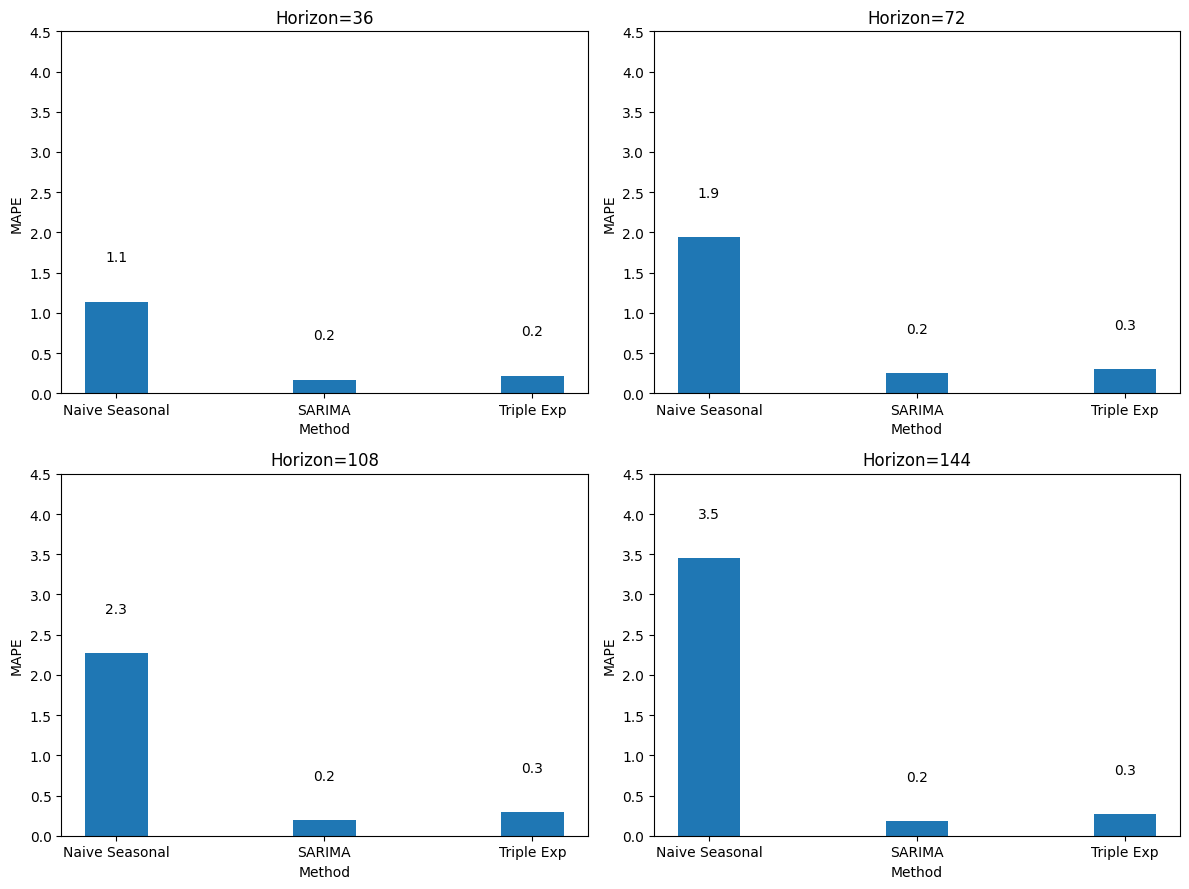

In [35]:
# Example numeric MAPE values
mape_naive_seasonal = [1.14, 1.94, 2.27, 3.45]
mape_SARIMA = [0.17, 0.25, 0.19, 0.18]
mape_triple_exp = [0.22, 0.3,0.29, 0.27]
windows = [36, 72, 108, 144]  # Horizon values

x_labels = ['Naive Seasonal', 'SARIMA', 'Triple Exp']
width = 0.3

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

# Iterate through subplots
for i, ax in enumerate(axes.flatten()):
    y = [mape_naive_seasonal[i], mape_SARIMA[i], mape_triple_exp[i]]  # Get numeric MAPE values for the current horizon
    x = range(len(x_labels))  # Indices for x-axis

    ax.bar(x, y, width, tick_label=x_labels)
    ax.set_xlabel('Method')
    ax.set_ylabel('MAPE')
    ax.set_ylim(0, 4.5)  # Set y-axis limit
    ax.set_title(f'Horizon={windows[i]}')
    
    # Add text annotations for bar heights
    for idx, value in enumerate(y):
        ax.text(x=idx, y=value + 0.5, s=f'{value:.1f}', ha='center')

plt.tight_layout()
plt.show()

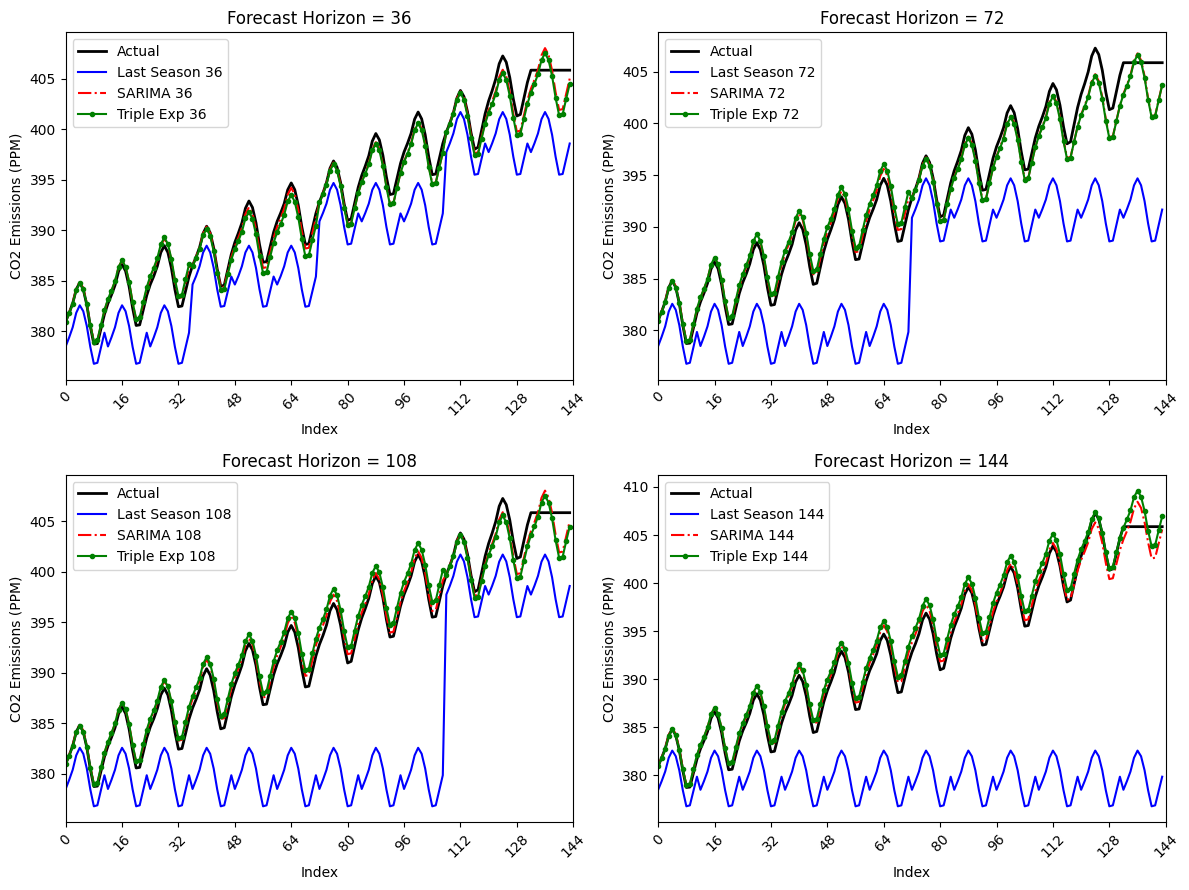

In [45]:
import matplotlib.pyplot as plt
import numpy as np

windows = [36, 72, 108, 144]  # Forecast horizons
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

for i, ax in enumerate(axes.flatten()):
    ax.plot(range(len(pred_df)), pred_df['CO2emissions'], label='Actual', color='black', linewidth=2)
    ax.plot(range(len(pred_df)), pred_df[f'pred_last_season_{windows[i]}'], 'b-', label=f'Last Season {windows[i]}')
    ax.plot(range(len(pred_df)), pred_df[f'pred_SARIMA_{windows[i]}'], 'r-.', label=f'SARIMA {windows[i]}')
    ax.plot(range(len(pred_df)), pred_df[f'pred_3_exp_{windows[i]}'], 'g.-', label=f'Triple Exp {windows[i]}')

    ax.legend(loc='best')
    ax.set_xlabel('Index')
    ax.set_ylabel('CO2 Emissions (PPM)')

    # Set x-axis limits from 0 to the length of pred_df
    ax.set_xlim(0, len(pred_df))

    # Define x-ticks at equal intervals
    tick_positions = np.linspace(0, len(pred_df), num=10, dtype=int)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions, rotation=45)

    ax.set_title(f'Forecast Horizon = {windows[i]}')

plt.tight_layout()
plt.show()

